在以下教程中，我们为字体设计师提供了一种使用Mindspore框架实现的CycleGAN在字体设计方面的衍生应用，该算法可以通过例如启智OpenI机器学习运算平台实现在线字体风格转化，为字体设计提供灵感。

## 1. CycleGAN模型介绍
[paper](https://arxiv.org/abs/1703.10593) :Zhu J Y , Park T , Isola P , et al. Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks[J]. 2017.

CycleGAN (Cycle Generative Adversarial Network) 即循环对抗生成网络，该模型实现了一种在没有配对示例的情况下学习将图像从源域 X 转换到目标域 Y 的方法。

如下图（a）所示，CycleGAN包含两个映射函数 G：X → Y 和 F：Y → X，并且有相应的对抗鉴别器 D<sub>Y</sub>和 D<sub>X</sub>。D<sub>Y</sub>鼓励 G 将 X 转换为与域 Y 中的输出不可区分的结果，D<sub>X</sub> 和 F 也是如此。为了进一步规范这些映射，CycleGAN还引入了两个循环一致性损失，用于获得这样的能力：如果模型从一个域翻译到另一个域，然后再返回，最终应该回到起始的位置。下图 (b)是正向循环一致性损失：x → G(x) → F(G(x)) ≈ x，以及 (c) 反向循环一致性损失：y → F(y) → G(F(y)) ≈ y。

<div style="align: center">
<img src="https://openi.pcl.ac.cn/cqu_lxy/CycleGAN_for_FontDesign/raw/branch/master/imgs/CycleGAN_framework.jpg" width="80%"/>
</div>

该模型一个重要应用领域是域迁移(Domain Adaptation)，可以通俗地理解为图像风格迁移。其实在 CycleGAN 之前，就已经有了域迁移模型，比如 Pix2Pix ，但是 Pix2Pix 要求训练数据必须是成对的，而现实生活中，要找到两个域（画风）中成对出现的图片是相当困难的，因此 CycleGAN 诞生了，它只需要两种域的数据，而不需要他们有严格对应关系，是一种新的无监督的图像迁移网络。

将CycleGAN训练好以后，可以通过加载模型参数文件，用训练好的模型来对图像进行推理，从而获得我们想要的风格转换后的图片。在本项目中，我们基于CyleGAN，使用竹叶图片将中文楷体汉字转换为竹叶风格字体，实现了字体风格化设计。我们所实现的竹叶体汉字的效果参考下图所示：

<div style="align: center">
<img src="https://openi.pcl.ac.cn/cqu_lxy/CycleGAN_for_FontDesign/raw/branch/master/imgs/result.png" width="80%"/>
</div>


## 2. 具体方法流程如下：
### 2.1 训练环境准备

* Mindspore 1.8.1（安装参考Mindspore文档：https://gitee.com/mindspore/docs/tree/r1.8/install ）
* NPU: 1 * Ascend 910, CPU: 24, 显存: 32GB, 内存: 96GB（本项目使用OpenI在线平台资源进行训练，具体流程请参考 https://openi.pcl.ac.cn/zeizei/OpenI_Learning ）

### 2.2 数据准备
* 获取：通过 OTF 或 TTF 字体库解包，获得需要进行转换的字体图片集。
* 预处理：通过裁剪边缘、二值化、重置图片大小等图片处理方法，将字体图片中的文字尽量居中，且在上下左右留出适当的距离。
* 选取其中一张楷体字体为带白底的 png 图片(256px * 256px，72dpi)用于推理，完成如以下“粉”字的风格转换：

<div style="align: center">
<img src="https://openi.pcl.ac.cn/cqu_lxy/CycleGAN_for_FontDesign/raw/branch/master/imgs/before_after.png" width="50%"/>
</div>


* 将准备好的图片放于`data/dataset/testA`路径内。
* 您可以从我们提供已处理好的数据集（包括训练集、验证集和测试集）直接下载选取：https://openi.pcl.ac.cn/cqu_lxy/CycleGAN_for_FontDesign/datasets

### 2.3 定义模型及推理相关参数
加载所需模块，并设定模型相关参数及推理过程相关参数。这里我们使用的模型是DepthResNet作为CycleGAN的生成器和判别器，平台为Ascend。其中`phase`必须设置为predict。

In [1]:
import sys
sys.path.append('.')

In [2]:
import os
import mindspore as ms
from src.models.cycle_gan import get_generator
from src.dataset.cyclegan_dataset import create_dataset
from src.utils.reporter import Reporter
from src.utils.tools import save_image, load_ckpt
import numpy as np

In [3]:
class Args():
    def __init__(self):
        self.model = "DepthResNet"
        self.in_planes = 3
        self.ngf = 64
        self.gl_num = 9
        self.slope = 0.2
        self.norm_mode = "batch"
        self.need_dropout = False
        self.init_type = "normal"
        self.init_gain = 0.02
        self.pad_mode = "CONSTANT"
        self.platform = "Ascend"
        self.save_graphs = False
        self.device_id = 0
        self.rank = 0
        self.device_num = 1
        self.phase = "predict"
        self.device_num = 1
        self.batch_size = 1
        self.rank = 0
        self.use_random = False
        self.max_dataset_size = float("inf")
        self.image_size = 256
        self.outputs_dir = "./outputs"
        

### 2.4 定义模型推理函数
在训练好CycleGAN并保存了模型参数ckpt文件的前提下，我们选取其中效果较好的epoch对应的ckpt文件路径，分别作为推理函数的`G_A_ckpt`, `G_B_ckpt`入参，并传入需要做风格变换的图像路径。在推理函数的实现中，会默认将推理结果的图片存放在`outputs/predict/fake_B`中。

推理函数中，我们首先需要定义生成器A和生成器B两个模型：
`G_A = get_generator(args)`，`G_B = get_generator(args)`
在推理过程中我们想要获得的是风格变换后的图片，因此不需要加载判别器A和判别器B。然后将传入的两个ckpt文件分别加载到对应的A和B上:`load_ckpt(args, G_A, G_B)`，获得和训练时效果较好的epoch对应模型具有一样生成能力的推理模型。生成的风格变换后的图像命名将默认为：`图像名_fake_B.jpg`，以jpg的格式进行保存。

In [4]:
def predict(G_A_ckpt, G_B_ckpt, image_pathes):
    """Predict function."""
    args = Args()
    if G_A_ckpt and G_B_ckpt:
        args.G_A_ckpt = G_A_ckpt
        args.G_B_ckpt = G_B_ckpt

    ms.set_context(mode=ms.GRAPH_MODE,
                   device_target=args.platform,
                   save_graphs=args.save_graphs)

    G_A = get_generator(args)
    G_B = get_generator(args)
    G_A.set_train(True)
    G_B.set_train(True)
    load_ckpt(args, G_A, G_B)
    
    imgs_out = os.path.join(args.outputs_dir, "predict")
    if not os.path.exists(imgs_out):
        os.makedirs(imgs_out)
    if not os.path.exists(os.path.join(imgs_out, "fake_A")):
        os.makedirs(os.path.join(imgs_out, "fake_A"))
    if not os.path.exists(os.path.join(imgs_out, "fake_B")):
        os.makedirs(os.path.join(imgs_out, "fake_B"))
    
    image_names = []
    for image_path in image_pathes:
        if image_path:
            args.image_name = image_path.split('/')[-1]
            image_names.append(args.image_name)
            args.data_dir = image_path.split('/')[-2]
            args.dataroot = image_path.replace(args.data_dir + '/' + args.image_name, '')
        
    ds = create_dataset(args)
    A_result, B_result = [], []
    
    for data in ds.create_dict_iterator(output_numpy=True):
        img_A = ms.Tensor(data["image"])
        path_A = data["image_name"][0]
        if isinstance(path_A, np.bytes_):
            path_A = path_A.decode("UTF-8")
        if path_A in image_names:
            path_B = path_A[0:-4] + "_fake_B.jpg"
            fake_B = G_A(img_A)
            save_image(fake_B, os.path.join(imgs_out, "fake_B", path_B))
            save_image(img_A, os.path.join(imgs_out, "fake_B", path_A))
            path_B = path_A[0:-4] + "_fake_B.jpg"
            B = os.path.join(imgs_out, "fake_B", path_B)
            A = os.path.join(imgs_out, "fake_B", path_A)
            A_result.append(A)
            B_result.append(B)
    
    return A_result, B_result

### 2.5 模型推理
在定义好推理过程后，准备好需要加载的生成器A和生成器B对应的模型参数文件路径`G_A_ckpt`和` G_B_ckpt`，然后指定需要做风格变换的楷体文字图片路径`img_path`。将以上3个参数传给推理函数`predict()`，获得的返回值有两个，分别是原图（A）和风格变化后的图片（B）。

In [5]:
G_A_ckpt, G_B_ckpt = './outputs/ckpt/G_A_30.ckpt', './outputs/ckpt/G_B_30.ckpt'
img_pathes = ['./data/dataset/testA/{}.png'.format(x) for x in range(30)]
A_result, B_result = predict(G_A_ckpt, G_B_ckpt, img_pathes)

[WARNING] ME(2536:281473290521280,MainProcess):2023-08-03-20:02:13.995.200 [mindspore/train/serialization.py:734] For 'load_param_into_net', remove parameter prefix name: generator.G_A., continue to load.
[WARNING] ME(2536:281473290521280,MainProcess):2023-08-03-20:02:14.803.78 [mindspore/train/serialization.py:734] For 'load_param_into_net', remove parameter prefix name: generator.G_B., continue to load.


### 2.6 可视化展示
使用`matplotlib`，将我们的楷体原图和风格变化后的竹叶体图片分别进行可视化展示，可以更直观地感受出通过CycleGAN模型我们实现汉字楷体向竹叶体风格变换的效果。当然，在训练的过程中，字体设计师还可以通过使用其他风格的图片（如花瓣、星星等）作为`trainB`来训练模型具有生成其他风格字体的能力。

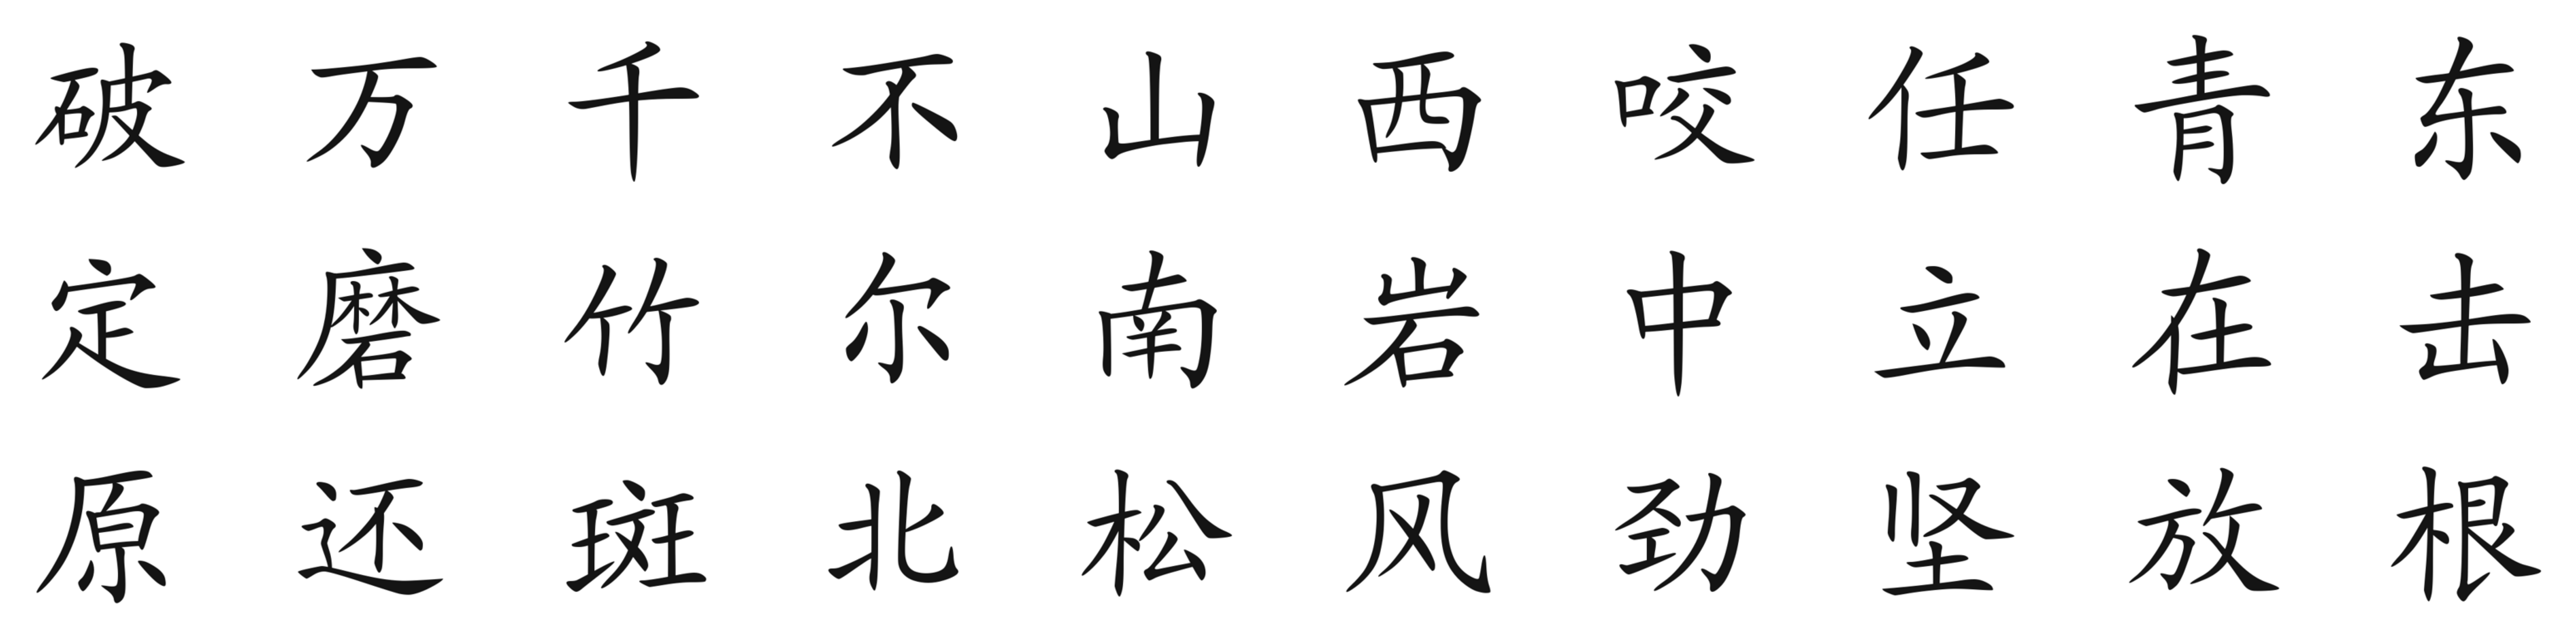

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig_A=plt.figure(figsize=(100,25))

columns = 10
rows = 3

for i in range(1, len(A_result) + 1):
    img = mpimg.imread(A_result[i-1])
    ax = fig_A.add_subplot(rows, columns, i)
    plt.axis('off') 
    plt.imshow(img)
plt.subplots_adjust(wspace =0, hspace =0)
plt.show()

可以看到我们选择的30个中文楷体字经过CycleGAN模型推理后，展示出了明显的竹叶风格的变化：

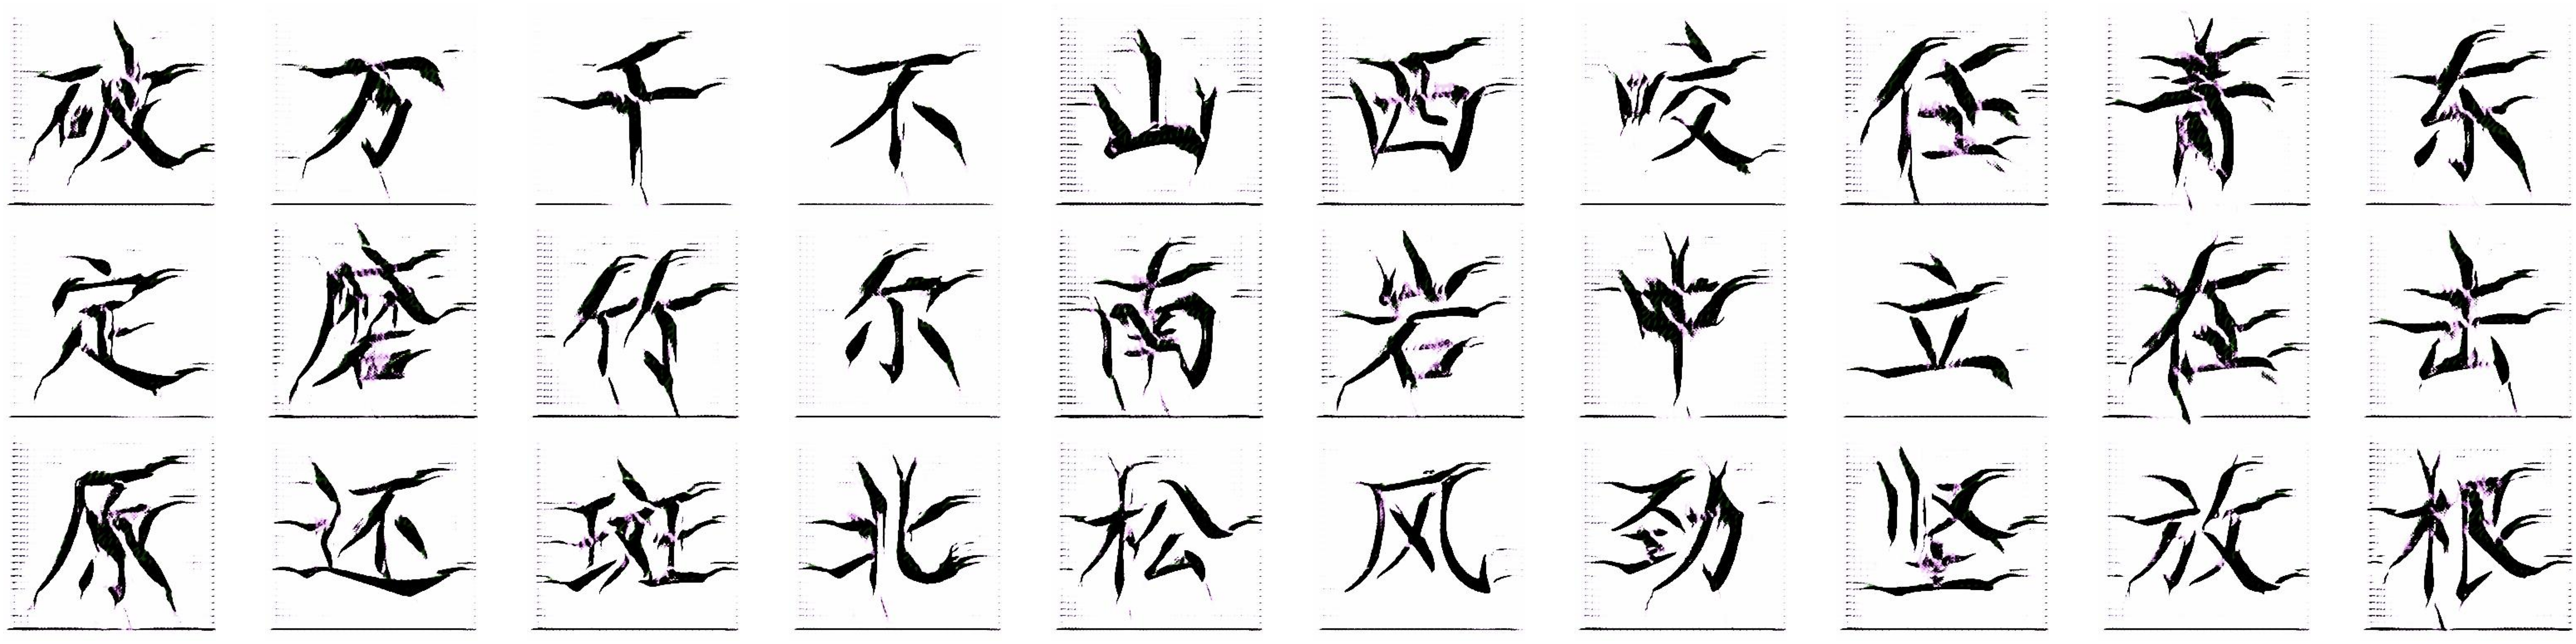

In [7]:
fig_B=plt.figure(figsize=(100,25))

for i in range(1, len(B_result) + 1):
    img = mpimg.imread(B_result[i-1])
    ax = fig_B.add_subplot(rows, columns, i)
    plt.axis('off') 
    plt.imshow(img)
plt.subplots_adjust(wspace =0, hspace =0)
plt.show()

## 3. 研究意义
设计师通过与人工智能算法协同合作，实现字体风格的高效转换。该设计项目旨在降低风格字体设计门槛，提升设计效率，不同阶段的生成结果能够在协同设计的过程启发设计师灵感，为人机协同艺术设计提供新的方法流程。

## 4. 参考文献
1. Paper: [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593)
2. GitHub：https://github.com/junyanz/CycleGAN
3. https://github.com/mindspore-ai/models/tree/master/official/cv/CycleGAN